In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Langevin Equation

$$ \gamma \dot{x} = -V^\prime _1 (x) - k_1 y + \sqrt{2k_B T_1 \gamma}ξ_1 $$
$$ \gamma \dot{y} = -V^\prime _2 (y) - k_2 x + \sqrt{2k_B T_2 \gamma}ξ_2 $$

$$ V_1 = \frac{a_1}{2} (x)^2, V_2 = \frac{a_2}{2} (y)^2 $$

$$ \dot{x} = -\frac{a_1}{\gamma} (x) - \frac{k_1}{\gamma} (y) + \sqrt{\frac{2k_B T_1}{\gamma}}ξ_1 $$
$$ \dot{y} = -\frac{a_2}{\gamma} (y) - \frac{k_2}{\gamma} (x) + \sqrt{\frac{2k_B T_2}{\gamma}}ξ_2 $$

Euler Scheme

$$ X_{t+\Delta t} = X_t + f(X_t, t)\Delta t + g(X_t,t)\Delta B_t $$

where $$ \Delta B_t = \mathcal{N}(0, \sqrt\Delta t) $$

### Stochastic Heat:

$$ 0 = - \gamma \dot{x} + \sqrt{2k_B T_1 \gamma}ξ_1 - V^\prime _1 (x) - k_1 y  $$
$$ 0 = - \gamma \dot{y} + \sqrt{2k_B T_2 \gamma}ξ_2 - V^\prime _2 (y) - k_2 x  $$

For x:

$$ \delta Q_1 = (-\gamma \dot{x} + \sqrt{2k_B T_1 \gamma}ξ_1) \circ dx  = (V^\prime _1 (x) + k_1 y) \circ dx$$

$$ \delta Q_1 = (a_1 x + k_1 y) \circ dx  $$

For y:

$$ \delta Q_2 = (-\gamma \dot{y} + \sqrt{2k_B T_2 \gamma}ξ_2) \circ dy  = (V^\prime _2 (y) + k_2 x) \circ dy$$

$$ \delta Q_2 = (a_2 y + k_2 x) \circ dy  $$

Functions for dynamics of Langevin equation:

In [2]:
def euler_one_traj(n_time, pars):   
    #initial condition
    x = 0
    y = 0
    x_traj = []
    y_traj = []
    
    #performing 1 traj with n_time number of data points
    for i in range(n_time):
        #generate delta_B
        s1 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        s2 = np.random.normal(0, np.sqrt(pars['delta_t']) )
        #solve for x, y
        x_new = x - (pars['a1']/pars['gamma'])*x*pars['delta_t'] - \
        (pars['k1']/pars['gamma'])*y*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T1'])/pars['gamma'])*s1
                 
        y_new = y - (pars['a2']/pars['gamma'])*y*pars['delta_t'] - \
        (pars['k2']/pars['gamma'])*x*pars['delta_t'] + \
        np.sqrt((2*pars['Kb']*pars['T2'])/pars['gamma'])*s2
                
        x = x_new
        y = y_new
        
        x_traj.append(x)
        y_traj.append(y)
    return x_traj, y_traj

In [3]:
def euler_n_traj(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    x_traj_list = []
    y_traj_list = []
    for i in range(pars['n_realizations']):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        x_traj_list.append(x_traj)
        y_traj_list.append(y_traj)
        
    return x_traj_list, y_traj_list, time

In [4]:
def plotter_traj(x_traj_list, y_traj_list):
    fig, ax = plt.subplots(1, 3, figsize=(15,3))

    for x in x_traj_list:
        ax[0].plot(time, x)
    for y in y_traj_list:
        ax[1].plot(time, y)
    for x,y in zip(x_traj_list, y_traj_list):
        ax[2].plot(x,y)

    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x')

    ax[1].set_xlabel('t')
    ax[1].set_ylabel('y')

    ax[2].set_xlabel('x')
    ax[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

In [5]:
def plotter_histogram(x_traj_list, y_traj_list, pars):
    #obtain the last element of x_traj_list
    x_list = []
    for x in x_traj_list:
        last_elementx = x[-1]
        x_list.append(last_elementx)

    #obtain the last element of y_traj_list
    y_list = []
    for y in y_traj_list:
        last_elementy = y[-1]
        y_list.append(last_elementy)

    mean_x = np.mean(x_list)
    std_x = np.std(x_list)
    mean_y = np.mean(y_list)
    std_y = np.std(y_list)


    plt.figure(figsize=(10,4))
    plt.hist(x_list, histtype='step', density = True, bins = 30, label='x')
    plt.hist(y_list, histtype='step', density = True, bins = 30, label='y')
    plt.title('x: Mean: {:.3g} and Std Dev: {:.3g} \n y: Mean: {:.3g} and Std Dev: {:.3g}'.format(mean_x, std_x, mean_y, std_y))
    
    plt.suptitle('T1: {}, T2: {}'.format(pars['T1'], pars['T2']))
    plt.xlabel('x')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Functions for stochastic heat

In [6]:
def calc_stochastic_heat_q1(x, y, pars):
    x_shift = np.roll(x, shift = 1)   
    y_shift = np.roll(y, shift = 1)
    
    x_ave = pars['a1']*((x + x_shift)/2)
    y_ave = pars['k1']*((y + y_shift)/2)
    dx = x - x_shift
    return (x_ave[1:] + y_ave[1:])*dx[1:]

def calc_stochastic_heat_q2(x, y, pars):
    x_shift = np.roll(x, shift = 1)   
    y_shift = np.roll(y, shift = 1)    
    
    y_ave = pars['a2']*((y + y_shift)/2)
    x_ave = pars['k2']*((x + x_shift)/2)
    dy = y - y_shift
    return (y_ave[1:] + x_ave[1:])*dy[1:]

In [7]:
#function to calculate average q after performing n_realizations
def average_q(max_time, pars):
    min_time = 0
    n_time = int((max_time - min_time)/pars['delta_t'] + 1) #n_time = num of evenly spaced samples (ex. 1001 points)
    time = np.linspace(min_time, max_time, n_time) #time(ex. 0 (min time), 0.01, 0.02, ..., 10 (max time)) with n_time no. of data points
    
    average_q1_trajectory = 0
    average_q2_trajectory = 0
    for i in range(pars['n_realizations']):
        x_traj, y_traj = euler_one_traj(n_time, pars)
        q1_trajectory = calc_stochastic_heat_q1(x_traj, y_traj, pars)
        q2_trajectory = calc_stochastic_heat_q2(x_traj, y_traj, pars)
        average_q1_trajectory += q1_trajectory/pars['n_realizations']
        average_q2_trajectory += q2_trajectory/pars['n_realizations']
        
    return average_q1_trajectory, average_q2_trajectory, time[:-1]

In [8]:
def stochastic_heat_plotter(q1, q2, pars):
    mean_q1 = np.mean(q1)
    std_q1 = np.std(q1)
    mean_q2 = np.mean(q2)
    std_q2 = np.std(q2)

    plt.figure(figsize=(10,4))
    plt.plot(time, q1, label = 'q1')
    plt.plot(time, q2, alpha = 0.5, label = 'q2')
    plt.title('q1: Mean: {:.3g} and Std Dev: {:.3g} \n q2: Mean: {:.3g} and Std Dev: {:.3g}'.format(mean_q1, std_q1, mean_q2, std_q2))

    plt.suptitle('T1: {}, T2: {}'.format(pars['T1'], pars['T2']))
    plt.xlabel('time')
    plt.ylabel('stochastic heat')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
#paramaters
pars = {}
pars['a1'] = 1
pars['k1'] = 1
pars['T1'] = 100
pars['a2'] = 1
pars['k2'] = 1
pars['T2'] = 100

pars['gamma'] = 1
pars['delta_t'] = 0.01
pars['Kb'] = 1.38*np.exp(-23)

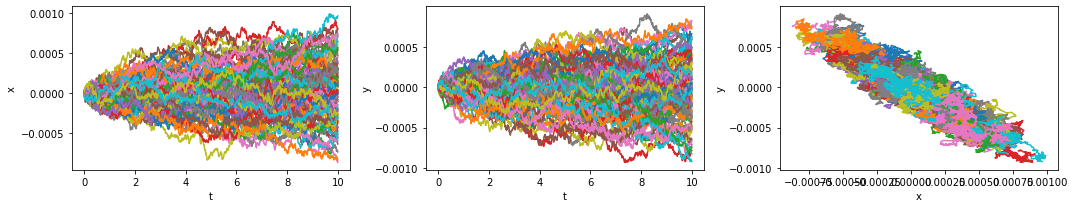

In [10]:
#plot trajectories with t = 10s
pars['n_realizations'] = 100
x_traj_list, y_traj_list, time = euler_n_traj(10, pars)
plotter_traj(x_traj_list, y_traj_list)

Plot probability distributions

Setting T1 = T2

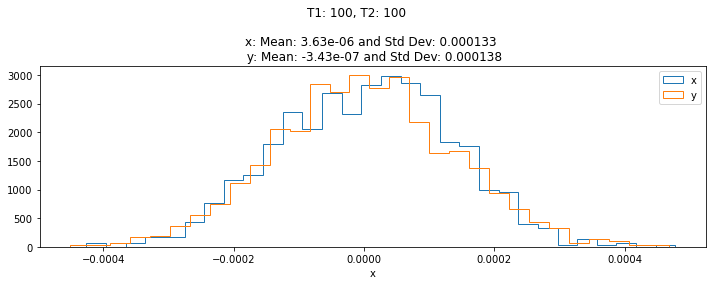

In [11]:
#plot histogram with t = 1s
pars['T1'] = 100
pars['T2'] = 100
pars['n_realizations'] = 1000
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
plotter_histogram(x_traj_list, y_traj_list, pars)

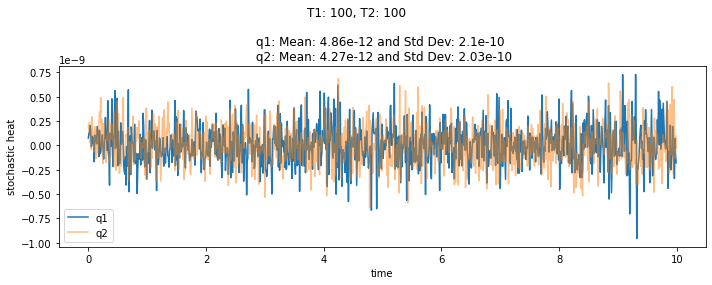

In [12]:
pars['n_realizations'] = 100
q1, q2, time = average_q(10, pars)
stochastic_heat_plotter(q1, q2, pars)

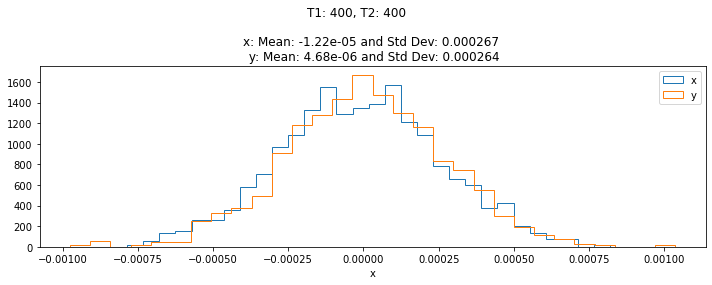

In [13]:
#plot histogram with t = 1s
pars['T1'] = 400
pars['T2'] = 400
pars['n_realizations'] = 1000
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
plotter_histogram(x_traj_list, y_traj_list, pars)

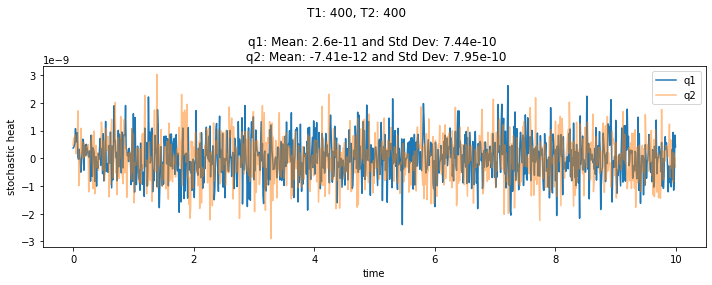

In [14]:
pars['n_realizations'] = 100
q1, q2, time = average_q(10, pars)
stochastic_heat_plotter(q1, q2, pars)

Mean and variance are of the same order for x and y when T1 = T2

Setting T2 > T1

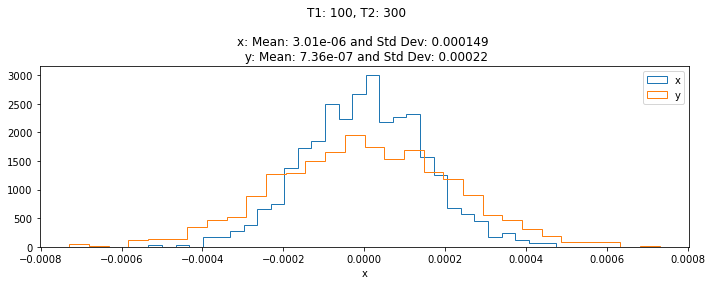

In [15]:
#plot histogram with t = 1s
pars['T1'] = 100
pars['T2'] = 300
pars['n_realizations'] = 1000
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
plotter_histogram(x_traj_list, y_traj_list, pars)

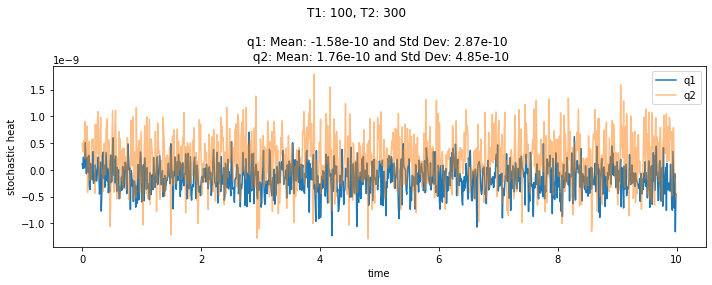

In [16]:
pars['n_realizations'] = 100
q1, q2, time = average_q(10, pars)
stochastic_heat_plotter(q1, q2, pars)

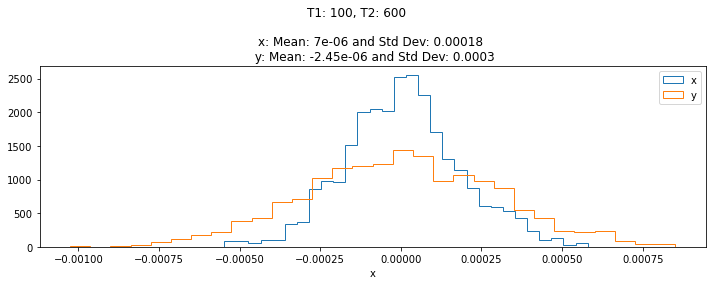

In [17]:
#plot histogram with t = 1s
pars['T1'] = 100
pars['T2'] = 600
pars['n_realizations'] = 1000
x_traj_list, y_traj_list, time = euler_n_traj(1, pars)
plotter_histogram(x_traj_list, y_traj_list, pars)

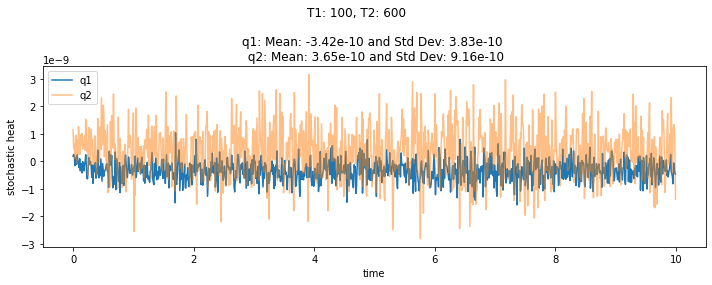

In [18]:
pars['n_realizations'] = 100
q1, q2, time = average_q(10, pars)
stochastic_heat_plotter(q1, q2, pars)

Mean and variance is larger for y when T2 > T1

Check for different temperatures

In [19]:
def calc_mean_std_diffT(T2_range, similarT=True):
    mean_x_list = []
    std_x_list = []
    mean_y_list = []
    std_y_list = []
    
    for i in T2_range:
        pars['T2'] = i
        if similarT == True:
            pars['T1'] = i
        else:
            pars['T1'] = 100
            
        x_traj_list, y_traj_list, time = euler_n_traj(1, pars)

        x_list = []
        for x in x_traj_list:
            last_elementx = x[-1]
            x_list.append(last_elementx)

        #obtain the last element of y_traj_list
        y_list = []
        for y in y_traj_list:
            last_elementy = y[-1]
            y_list.append(last_elementy)

        mean_x = np.mean(x_list)
        std_x = np.std(x_list)
        mean_y = np.mean(y_list)
        std_y = np.std(y_list)

        mean_x_list.append(mean_x)
        std_x_list.append(std_x)
        mean_y_list.append(mean_y)
        std_y_list.append(std_y)
    return mean_x_list, std_x_list, mean_y_list, std_y_list

In [20]:
%%time
pars['n_realizations'] = 1000
T2_range = np.linspace(100,1000,50)
mean_x_list, std_x_list, mean_y_list, std_y_list = calc_mean_std_diffT(T2_range,similarT=True)

Wall time: 3min 37s


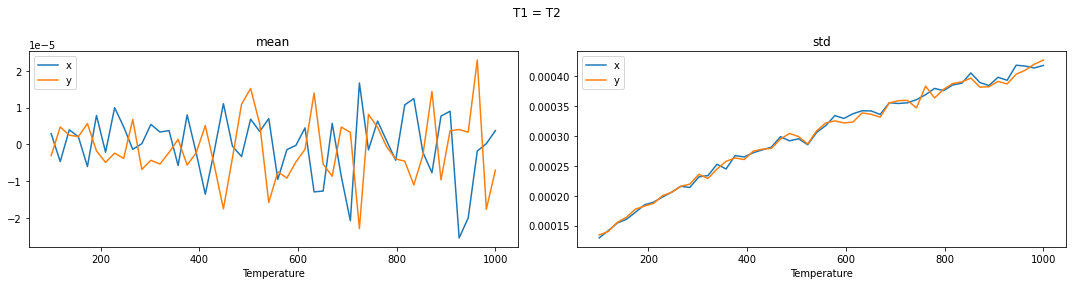

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(T2_range, mean_x_list, label='x')
ax[0].plot(T2_range, mean_y_list, label='y')

ax[1].plot(T2_range, std_x_list, label='x')
ax[1].plot(T2_range, std_y_list,label='y')

ax[0].set_title('mean')
ax[1].set_title('std')

ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('Temperature')

plt.suptitle('T1 = T2')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

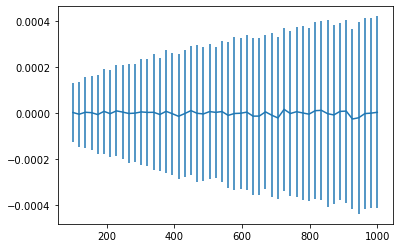

In [22]:
#if I plot the mean and std in one plot, std is too large 
plt.errorbar(T2_range, mean_x_list, std_x_list)
plt.show()

In [23]:
%%time
pars['n_realizations'] = 1000
T2_range = np.linspace(100,1000,50)
mean_x_list, std_x_list, mean_y_list, std_y_list = calc_mean_std_diffT(T2_range,similarT=False)

Wall time: 1min 20s


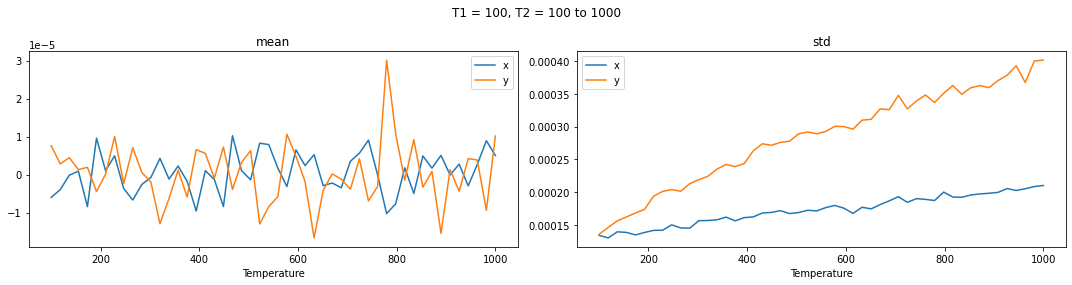

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(T2_range, mean_x_list, label='x')
ax[0].plot(T2_range, mean_y_list, label='y')

ax[1].plot(T2_range, std_x_list, label='x')
ax[1].plot(T2_range, std_y_list,label='y')

ax[0].set_title('mean')
ax[1].set_title('std')

ax[0].set_xlabel('Temperature')
ax[1].set_xlabel('Temperature')

plt.suptitle('T1 = 100, T2 = 100 to 1000')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()